In [26]:
import os
import glob
import pickle

import numpy as np
from scipy import signal
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt

In [12]:
resol = 0.1*u.second

In [3]:
files = sorted(glob.glob('*.log'))
print(files)

['010618_21_N2_00_part_pulse.log', '020618_21_N2_00_part_pulse.log', '030618_21_N2_00_part_pulse.log', '040618_21_N2_00_part_pulse.log', '050618_21_N2_00_part_pulse.log']


In [9]:
full_data = []
for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
    full_data.append(data)

In [27]:
joined_array = full_data[0][2]
for i in range(1,len(full_data)):
    dt = full_data[i][1] - full_data[i-1][1] 
    zeros = np.zeros(int(round((dt.to(u.second)/resol).value, 0)))
    joined_array = np.append(joined_array, zeros)
    joined_array = np.append(joined_array, full_data[i][2])

In [28]:
len(joined_array)

3461614

In [43]:
fs = 10 # понять физический смысл этого числа
f, Pxx_den = signal.periodogram(joined_array, fs)

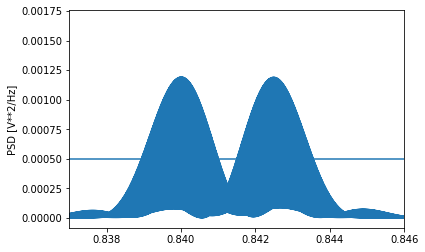

In [46]:
plt.plot(f, Pxx_den)
plt.ylabel('PSD [V**2/Hz]')
plt.axhline(0.3*max(Pxx_den))
#plt.ylim(0, 0.00003)
plt.xlim(0.837, 0.846)
plt.show()

In [36]:
_, points = np.where([Pxx_den > 0.3*max(Pxx_den)])

In [31]:
for i in points:
    print(f[i], f[i]/f[points[0]], (f[i])/(f[i]/f[points[0]]))

1.1555303393157064e-05 1.0 1.1555303393157064e-05
2.3110606786314127e-05 2.0 1.1555303393157064e-05
3.466591017947119e-05 2.9999999999999996 1.1555303393157064e-05
4.6221213572628255e-05 4.0 1.1555303393157064e-05
5.777651696578532e-05 5.0 1.1555303393157064e-05
6.933182035894238e-05 5.999999999999999 1.1555303393157064e-05
8.088712375209944e-05 7.0 1.1555303393157064e-05
9.244242714525651e-05 8.0 1.1555303393157064e-05
0.00010399773053841358 9.0 1.1555303393157064e-05
0.00011555303393157064 10.0 1.1555303393157064e-05
0.0001271083373247277 11.0 1.1555303393157065e-05
0.00013866364071788475 11.999999999999998 1.1555303393157064e-05
0.00015021894411104182 13.0 1.1555303393157064e-05
0.00016177424750419888 14.0 1.1555303393157064e-05
0.00017332955089735595 15.0 1.1555303393157064e-05
0.00018488485429051302 16.0 1.1555303393157064e-05
0.00019644015768367009 17.0 1.1555303393157064e-05
0.00020799546107682715 18.0 1.1555303393157064e-05
0.00021955076446998422 19.0 1.1555303393157064e-05
0.0

0.8427976082833036 72936.0 1.1555303393157064e-05
0.8428091635866968 72937.0 1.1555303393157064e-05
0.8428207188900899 72938.0 1.1555303393157064e-05
0.842832274193483 72939.0 1.1555303393157064e-05
0.8428438294968762 72940.0 1.1555303393157064e-05
0.8428553848002693 72941.0 1.1555303393157064e-05
0.8428669401036626 72942.0 1.1555303393157064e-05
0.8428784954070557 72943.0 1.1555303393157064e-05
0.8428900507104489 72944.0 1.1555303393157064e-05
0.842901606013842 72945.0 1.1555303393157064e-05
0.8429131613172351 72946.0 1.1555303393157064e-05
0.8429247166206283 72947.0 1.1555303393157064e-05
0.8429362719240214 72948.0 1.1555303393157064e-05
0.8429478272274147 72949.0 1.1555303393157064e-05
0.8429593825308078 72950.0 1.1555303393157064e-05
0.842970937834201 72951.0 1.1555303393157064e-05
0.8429824931375941 72952.0 1.1555303393157064e-05
0.8429940484409872 72953.0 1.1555303393157064e-05
0.8430056037443804 72954.0 1.1555303393157064e-05
0.8430171590477736 72955.0 1.1555303393157064e-05
0.8

2.522320512916807 218282.50000000003 1.1555303393157064e-05
2.5223320682201997 218283.49999999997 1.1555303393157064e-05
2.522343623523593 218284.5 1.1555303393157064e-05
2.5223551788269862 218285.5 1.1555303393157064e-05
2.5223667341303795 218286.5 1.1555303393157064e-05
2.5223782894337727 218287.50000000003 1.1555303393157064e-05
2.5223898447371655 218288.5 1.1555303393157064e-05
2.522401400040559 218289.5 1.1555303393157064e-05
2.522412955343952 218290.5 1.1555303393157064e-05
2.5224245106473453 218291.5 1.1555303393157064e-05
2.522436065950738 218292.49999999997 1.1555303393157064e-05
2.5224476212541314 218293.5 1.1555303393157064e-05
2.5224591765575246 218294.5 1.1555303393157064e-05
2.522470731860918 218295.5 1.1555303393157064e-05
2.522482287164311 218296.5 1.1555303393157064e-05
2.522493842467704 218297.49999999997 1.1555303393157064e-05
2.522505397771097 218298.5 1.1555303393157064e-05
2.5225169530744904 218299.5 1.1555303393157064e-05
2.5225285083778837 218300.5 1.15553033931

3.365083455289931 291215.5 1.1555303393157064e-05
3.365095010593324 291216.5 1.1555303393157064e-05
3.365106565896717 291217.5 1.1555303393157064e-05
3.3651181212001102 291218.5 1.1555303393157064e-05
3.3651296765035035 291219.5 1.1555303393157064e-05
3.3651412318068967 291220.5 1.1555303393157064e-05
3.36515278711029 291221.5 1.1555303393157064e-05
3.365164342413683 291222.5 1.1555303393157064e-05
3.365175897717076 291223.5 1.1555303393157064e-05
3.3651874530204693 291224.5 1.1555303393157064e-05
3.3651990083238625 291225.5 1.1555303393157064e-05
3.365210563627256 291226.5 1.1555303393157064e-05
3.3652221189306486 291227.5 1.1555303393157064e-05
3.365233674234042 291228.5 1.1555303393157064e-05
3.365245229537435 291229.5 1.1555303393157064e-05
3.3652567848408284 291230.5 1.1555303393157064e-05
3.3652683401442216 291231.5 1.1555303393157064e-05
3.3652798954476144 291232.5 1.1555303393157064e-05
3.3652914507510077 291233.5 1.1555303393157064e-05
3.365303006054401 291234.5 1.155530339315